In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import geopandas as gpd
import pyproj
from shapely.ops import transform
from Funciones.GEO_LIB import Plot, Poligono, Distancia, Geodecodificacion
import warnings
warnings.filterwarnings("ignore")

# Análisis 1: Mercado-Reporte Industria

### 1. Cantidad de visitas

**A continuación, se llevará a cabo un análisis de la cantidad de visitas de los casinos ubicados en la región de Los Lagos: Enjoy Chiloé, Sun Dreams Puerto Varas y Casino Marina del Sol de Osorno. Esta información será contrastada con la cantidad de reseñas recibidas por cada casino en cada año.**

In [2]:
# Lectura del archivo mercado
mercado = pd.read_excel('Base de datos/Mercado-Reporte Industria Filtrado.xlsx')
mercado = mercado[['Casino','Valor','AñoMes']]

# Convertir 'AñoMes' al formato datetime
mercado['AñoMes'] = pd.to_datetime(mercado['AñoMes'], format='%Y%m')
mercado.head()

,Casino,Valor,AñoMes
0,Enjoy Chiloé,9074.0,2016-01-01
1,Enjoy Chiloé,12157.0,2016-02-01
2,Enjoy Chiloé,7340.0,2016-03-01
3,Enjoy Chiloé,7627.0,2016-04-01
4,Enjoy Chiloé,3544.0,2016-05-01


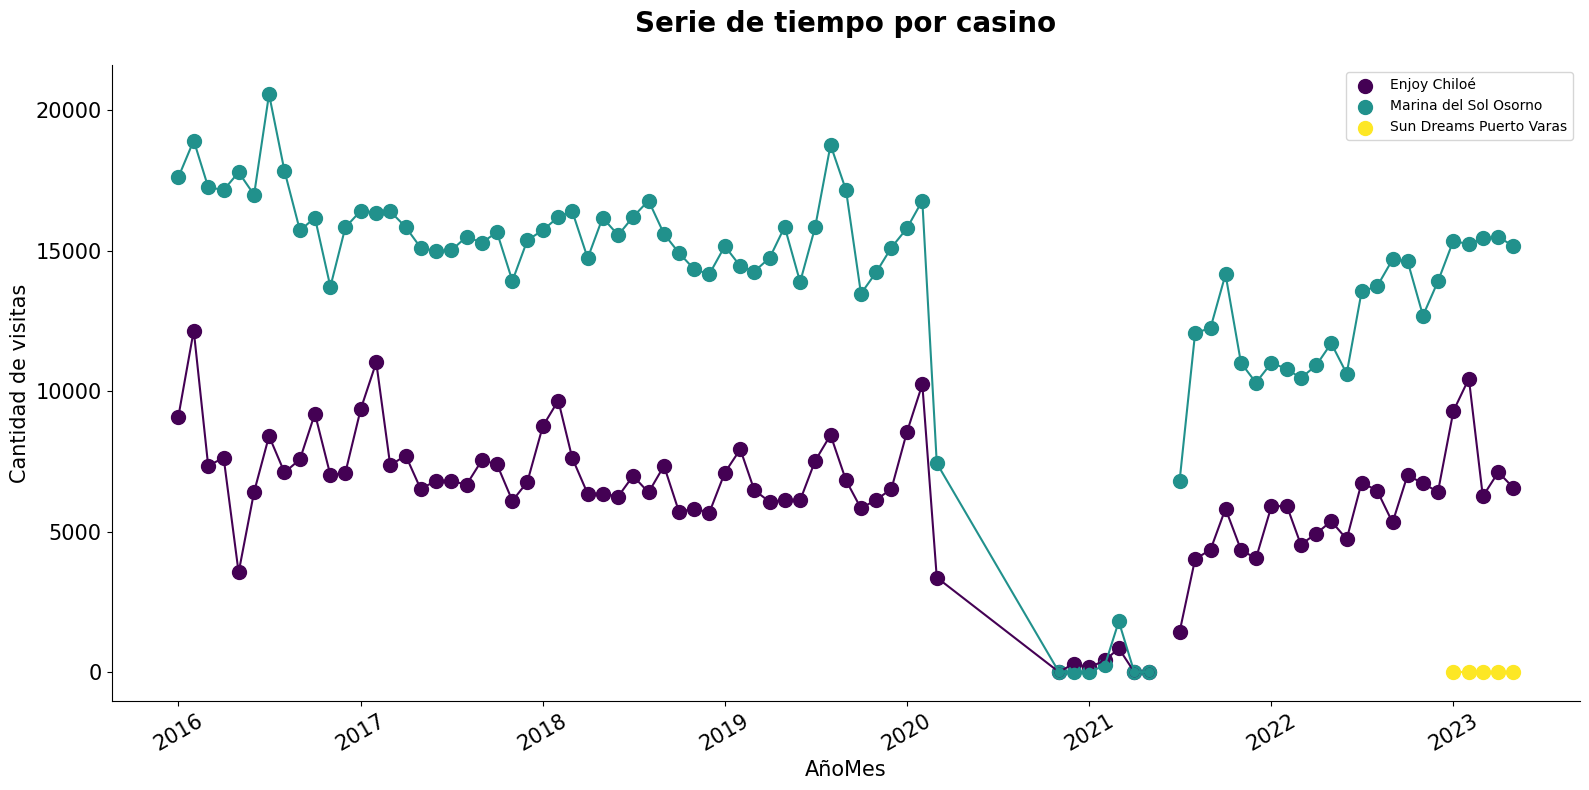

In [3]:
def hide_border(ax):
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Crear un gráfico de puntos y líneas para cada casino
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# Define a color map for categories
color_map = cm.get_cmap('viridis', len(mercado['Casino'].unique()))

# Iterate over each unique category and plot the data points
for i, category in enumerate(mercado['Casino'].unique()):
    category_data = mercado[mercado['Casino']== category]
    if category == 'Puerto Varas':
        ax.scatter(category_data['AñoMes'],category_data['Valor'],  c=color_map(i), label='Sun Dreams '+category, s=100)
    else:
        ax.scatter(category_data['AñoMes'],category_data['Valor'],  c=color_map(i), label=category, s=100)
    ax.plot(category_data['AñoMes'],category_data['Valor'], '-o', c=color_map(i))


ax.set_xlabel("AñoMes", fontsize=15)
ax.set_ylabel("Cantidad de visitas", fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=30, fontsize=15)
plt.yticks(fontsize=15)
ax.set_title("Serie de tiempo por casino", pad=24, fontweight=700, fontsize=20)
hide_border(ax)
ax.legend()  # Show the legend with category labels
fig.tight_layout()

**Se observa que el casino Marina del Sol carece de datos sobre la cantidad de visitas. Asimismo, se evidencia una disminución en la afluencia de visitantes en los casinos Enjoy y Sun Dreams durante los periodos de cuarentena. Por lo tanto, se procederá a excluir los años 2020 y 2021 de la serie temporal, ya que corresponden a los años en los que se implementaron medidas de cuarentena.**

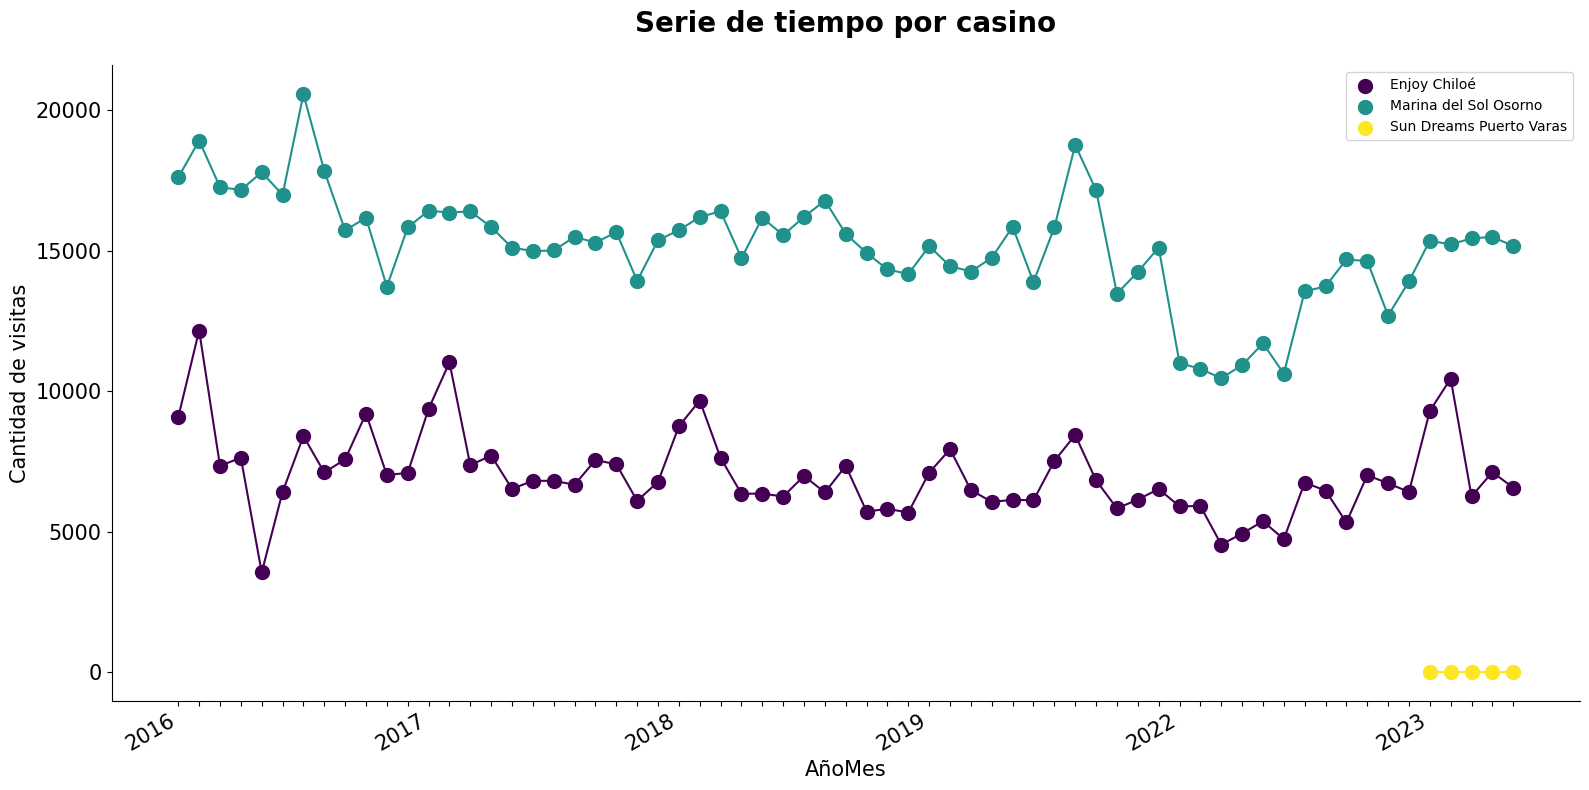

In [4]:
# Eliminar las filas que cumplen la condición
filt = (mercado['AñoMes'].dt.year != 2020) & (mercado['AñoMes'].dt.year != 2021)
mercado_filtrado = mercado[filt]
mercado_filtrado['AñoMes_str'] = mercado_filtrado['AñoMes'].dt.strftime('%Y-%m-%d')

# Crear un gráfico de puntos y líneas para cada casino
fig, ax = plt.subplots(figsize=(16, 8))
color_map = cm.get_cmap('viridis', len(mercado_filtrado['Casino'].unique()))

for i, category in enumerate(mercado_filtrado['Casino'].unique()):
    category_data = mercado_filtrado[mercado_filtrado['Casino'] == category]
    label = 'Sun Dreams ' + category if category == 'Puerto Varas' else category
    ax.scatter(category_data['AñoMes_str'], category_data['Valor'], c=color_map(i), label=label, s=100)
    ax.plot(category_data['AñoMes_str'], category_data['Valor'], '-o', c=color_map(i))

ax.set_xlabel("AñoMes", fontsize=15)
ax.set_ylabel("Cantidad de visitas", fontsize=15)
#ax.set_xticks(['2015','2016','2017','2018','2019','2022','2023'])  
anios = ['2016','','','','','','','','','','', '',
                    '2017', '','','','','','','','','','', '',
                    '2018','','','','','','','','','','', '',
                    '2019','','','','','','','','','','', '',
                    '2022','','','','','','','','','','', '',
                    '2023','','','','','','','','']
ax.set_xticklabels(anios)
plt.xticks(rotation=30,ha='right', fontsize=15)
plt.yticks(fontsize=15)
ax.set_title("Serie de tiempo por casino", pad=24, fontweight=700, fontsize=20)
ax.legend()  # Show the legend with category labels
hide_border(ax)
fig.tight_layout()

plt.show()

### 1.2. Cantidad de comentarios

**A continuación se realizará una figura que indica la cantidad de comentarios que hay por cada casino anterior**

In [5]:
# Lectura de archivo que contiene los comentarios de los lugares
datos_original = pd.read_excel('Base de datos/Base de datos Chiloe Full.xlsx').reset_index()
datos = datos_original.copy()
datos = datos.rename({'index':'Id'}, axis='columns')

**Los Place Id de los casinos son los siguientes:**

    1. Enjoy: ChIJ-7i9GcIZIpYR8RXUXrIVowE
    2. Marina: ChIJ51rRbY02FpYRCGQO7YRmONc
    3. Sun Dreams: ChIJK5aEQtcmGJYRH7i05Q_XUUs


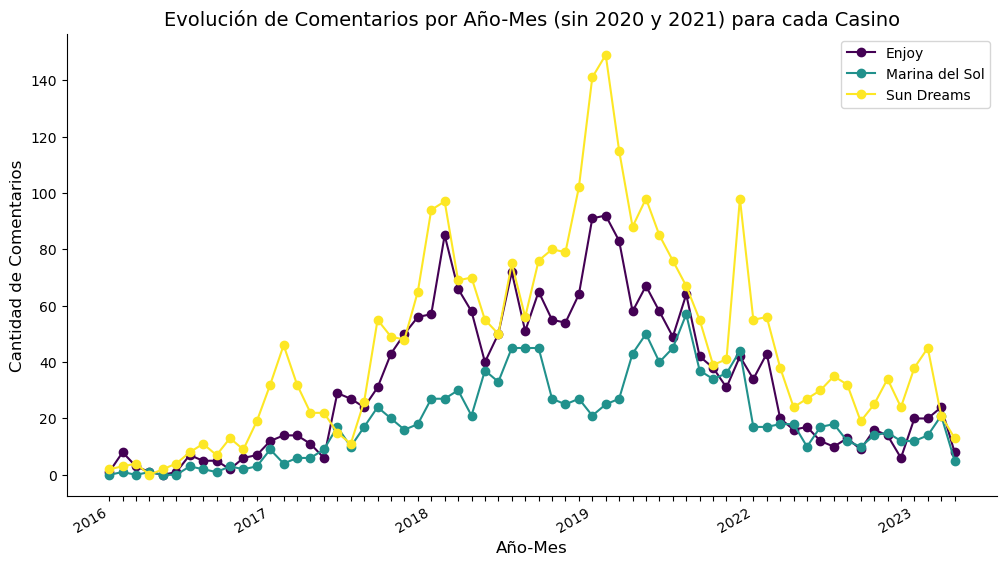

In [6]:
# Convertir 'publishedAtDate' a tipo datetime
datos['publishedAtDate'] = pd.to_datetime(datos['publishedAtDate'])

# Crear columna de año-mes
datos['AñoMes'] = datos['publishedAtDate'].dt.to_period('M')

# Filtrar el DataFrame para incluir solo los 'placeId' especificados
place_ids = ['ChIJ-7i9GcIZIpYR8RXUXrIVowE', 'ChIJ51rRbY02FpYRCGQO7YRmONc', 'ChIJK5aEQtcmGJYRH7i05Q_XUUs']
filtered_data = datos[datos['placeId'].isin(place_ids)]

# Se eliminan los años de cuarentena y los años 2013, 2014, y 2015, ya que no hay registros de estos años en la cantidad de visitas
filtered_data = filtered_data[~filtered_data['AñoMes'].dt.year.isin([2013, 2014, 2015, 2020, 2021])]

# Contar la cantidad de comentarios ('reviewId') por 'Año-Mes' y 'placeId'
grouped_data = filtered_data.groupby(['AñoMes', 'placeId'])['reviewId'].count().unstack().fillna(0)

# Crear un gráfico de líneas para cada 'placeId'
fig, ax = plt.subplots(figsize=(12, 6))
casinos = ['Enjoy','Marina del Sol','Sun Dreams']
color_map = cm.get_cmap('viridis', len(place_ids))
for n,place_id in enumerate(place_ids):
    ax.plot(grouped_data.index.astype(str), grouped_data[place_id], marker='o', label=casinos[n],c=color_map(n))

ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de Comentarios', fontsize=12)
ax.set_xticklabels(anios)
ax.set_title('Evolución de Comentarios por Año-Mes (sin 2020 y 2021) para cada Casino', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()


## 1.3 Análisis de correlación 
**Correlación de Pearson: La correlación de Pearson se utiliza para medir la relación lineal entre dos variable**

In [7]:
# Pivoteamos el DataFrame para reorganizarlo
pivot_df = mercado_filtrado.pivot(index='AñoMes_str', columns='Casino', values='Valor')
pivot_df = pivot_df.fillna(0)
pivot_df.columns = ['Enjoy', 'Marina del Sol', 'Sun Dreams']
grouped_data.columns = ['Enjoy', 'Marina del Sol', 'Sun Dreams']
pivot_df = pivot_df.reset_index(drop=True)
grouped_data = grouped_data.reset_index(drop=True)

# Calcular la correlación de Pearson
correlacion_pearson = pivot_df.corrwith(grouped_data, axis=0)

# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson)

Correlación de Pearson entre las columnas:
Enjoy            -0.063664
Marina del Sol   -0.073675
Sun Dreams             NaN
dtype: float64


# Análisis 2: Viajes ocasionales
### 2.1 Cantidad de viajes hacia una comuna de la Región de Los Lagos

**Viajes turísticos ocasionales: El viaje no se repite al mismo destino principal en  3 meses. Antes denominados "viajes turísticos no frecuentes"**

In [8]:
# Lectura del archivo mercado
viajes = pd.read_excel('Base de datos/Viajes ocasionales filtrado.xlsx')


# Reordenar y organizar el DataFrame
df_reordenado = (pd.melt(viajes, id_vars=['Comuna Destino ', 'Anio '], 
                         value_vars=['Ene ', 'Feb ', 'Mar ', 'Abr ', 'May ', 'Jun ', 'Jul ', 'Ago ', 'Sep ', 'Oct ', 'Nov ', 'Dic '],
                         var_name='Mes', value_name='Valor')
                 .assign(Mes=lambda x: x['Mes'].str.strip())
                 .sort_values(by=['Comuna Destino ', 'Anio ', 'Mes'])
                 .rename(columns={'Comuna Destino ': 'Comuna', 'Anio ': 'Año'}))

# Sumar los valores por comuna, año y mes
df_reordenado['Valor'] = df_reordenado['Valor'].apply(lambda x: float(x.replace(',', '.')) if pd.notnull(x) else x)
df_suma = (df_reordenado.groupby(['Comuna', 'Año', 'Mes'])['Valor']
                       .sum()
                       .reset_index())


# Diccionario para mapear nombres de meses a números
meses_a_numeros = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
}

# Mapear los nombres de los meses a números
df_suma['Mes_Numero'] = df_suma['Mes'].map(meses_a_numeros)

# Convertir 'Anio' a tipo numérico
df_suma['Año'] = pd.to_numeric(df_suma['Año'], errors='coerce')

# Crear la columna 'Anio-Mes'
df_suma['Anio-Mes'] = pd.to_datetime(df_suma['Año'].astype(str) + '-' + df_suma['Mes_Numero'].astype(str).str.zfill(2))
df_suma.head()

,Comuna,Año,Mes,Valor,Mes_Numero,Anio-Mes
0,Ancud,2019,Abr,6245.708259,4,2019-04-01
1,Ancud,2019,Ago,6206.432268,8,2019-08-01
2,Ancud,2019,Dic,9777.811576,12,2019-12-01
3,Ancud,2019,Ene,22677.810296,1,2019-01-01
4,Ancud,2019,Feb,27735.834566,2,2019-02-01


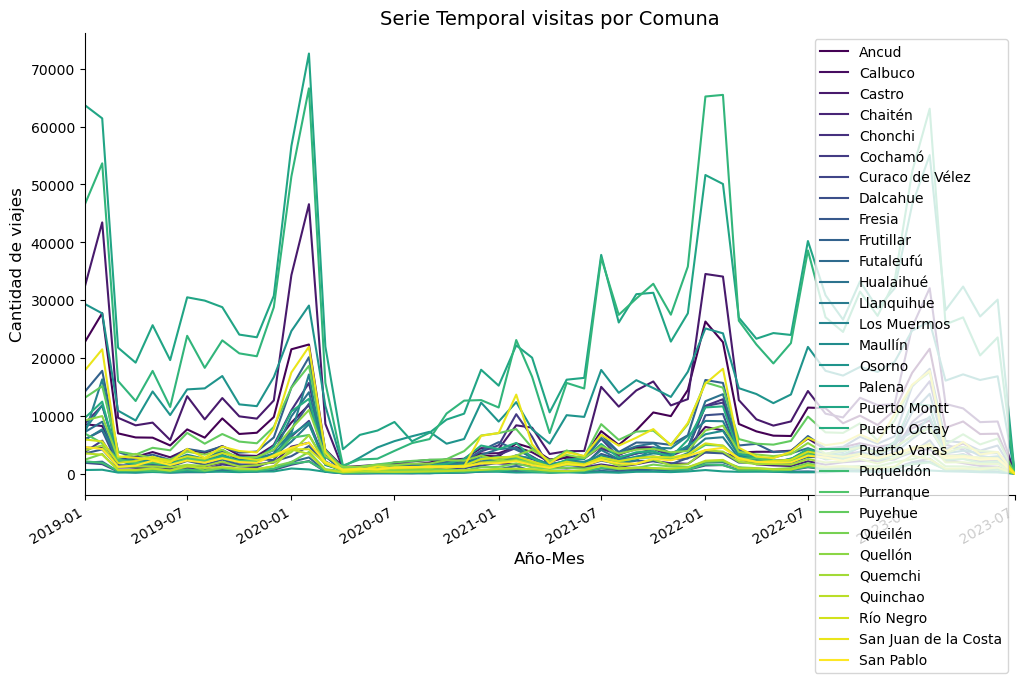

In [9]:
# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', len(df_suma['Comuna'].unique()))

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Iterar a través de cada comuna y trazar su serie temporal
for i, comuna in enumerate(df_suma['Comuna'].unique()):
    datos_comuna = df_suma[df_suma['Comuna'] == comuna]
    datos_comuna = datos_comuna.sort_values(by='Anio-Mes')
    ax.plot(datos_comuna['Anio-Mes'], datos_comuna['Valor'], label=comuna, color=color_map(i))

ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de viajes', fontsize=12)
ax.set_title('Serie Temporal visitas por Comuna', fontsize=14)
ax.legend()
ax.set_xlim(datos_comuna['Anio-Mes'].min(), pd.to_datetime('2023-07-01'))
plt.xticks(rotation=30, ha='right')
hide_border(ax)
plt.show()


### 2.1.a Correlación

**Correlación de los comentarios entre las comunas**

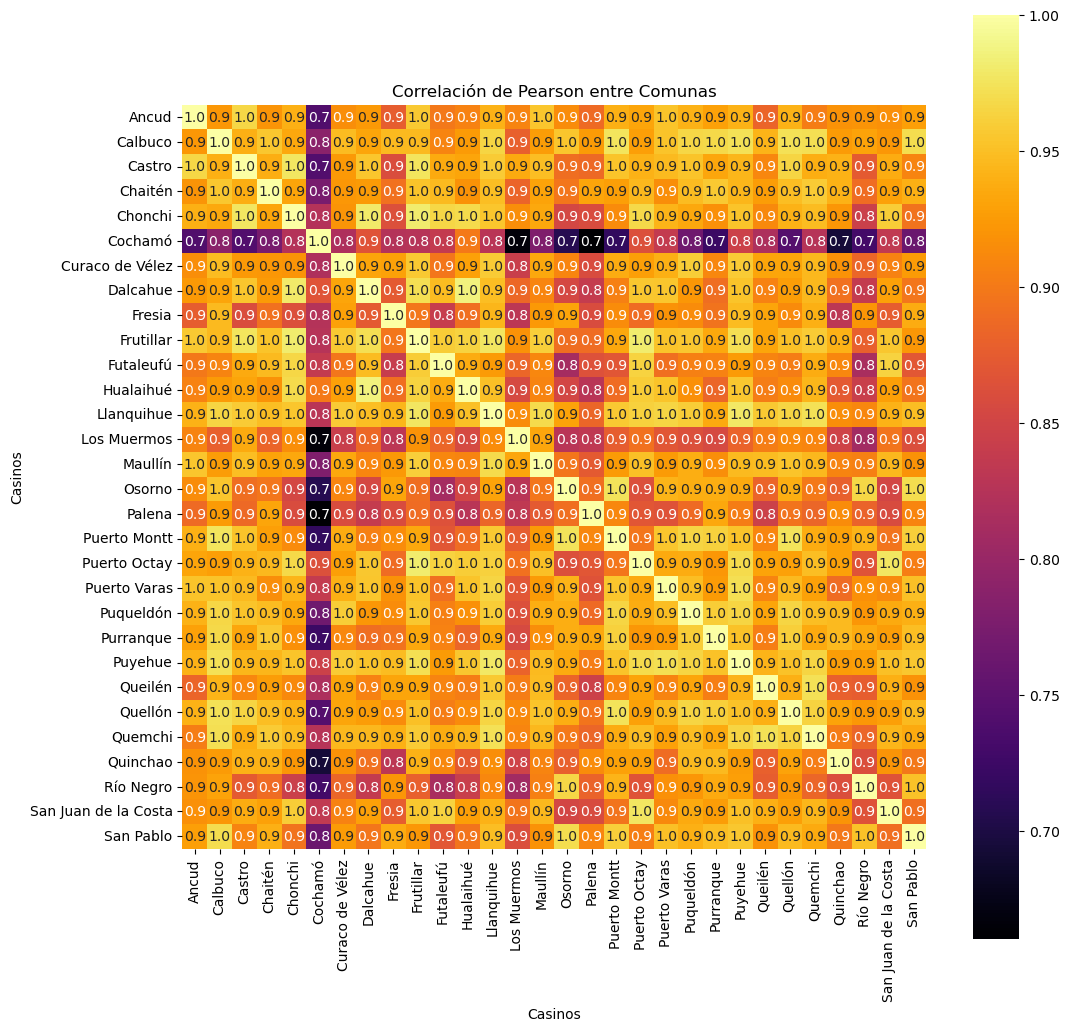

In [10]:
# Pivoteamos el DataFrame para reorganizarlo
pivot_df = df_suma.pivot(index='Anio-Mes', columns='Comuna', values='Valor')

# Calcular la correlación de Pearson
correlacion_pearson = pivot_df.corr()
correlacion_pearson = correlacion_pearson.fillna(0)

# Graficar el heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlacion_pearson, annot=True, cmap='inferno', cbar=True, square=True, fmt='.1f')
plt.xlabel('Casinos')
plt.ylabel('Casinos')
plt.title('Correlación de Pearson entre Comunas')
plt.show()

### 2.2 Cantidad de comentarios por comuna

**A continuación se asignará la comunda a la que pertenece cada lugar. Para esto se empleará los langotudes y latitudes**

In [11]:
# Combina los datos de 'places_id' con las columnas 'placeId', 'latitude' y 'longitude' de 'datos'
# Preparación del GeoDataFrame 'geo_clientes'
geo_clientes = datos_original.rename(columns={'latitude': 'Latitud', 'longitude': 'Longitud'})
geo_clientes = gpd.GeoDataFrame(geo_clientes, geometry=gpd.points_from_xy(geo_clientes['Latitud'], geo_clientes['Longitud']), crs='EPSG:4326').drop_duplicates()

# Filtrado de 'zona' por provincias y reinicio de índices
provincias = ['Osorno', 'Palena', 'Llanquihue', 'Chiloe']
zona = (gpd.read_file('Base de datos/Comunas/comunas.shp')
        .loc[lambda df: df['Provincia'].isin(provincias)]
        .reset_index(drop=True)
        .reset_index()
        .rename(columns={'index': 'Index'}))



# Se inicializa la columna 'conversion' con valor 0
zona['conversion'] = 0  
for i in range(len(zona)):
    # Se define los sistemas de referencia de coordenadas
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS('EPSG:3857')
    # Se crea un transformador de coordenadas de UTM a WGS84
    project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    # Transforma la geometría de la zona actual de UTM a WGS84
    s_new = transform(project, zona['geometry'].iloc[i])
    # Asigna el resultado de la transformación a la columna 'conversion' en la fila actual
    zona['conversion'].iloc[i] = s_new


# Obtención de clientes por distrito y creación de DataFrame
clientes = [Poligono.Interior_Poligono(geo_clientes, zona["conversion"].iloc[i]) for i in range(len(zona))]
df_concatenado = pd.concat([pd.DataFrame({'placeId': clientes[i]['placeId'].unique(), 'Comuna': zona['Comuna'].iloc[i]}) for i in range(len(zona))])

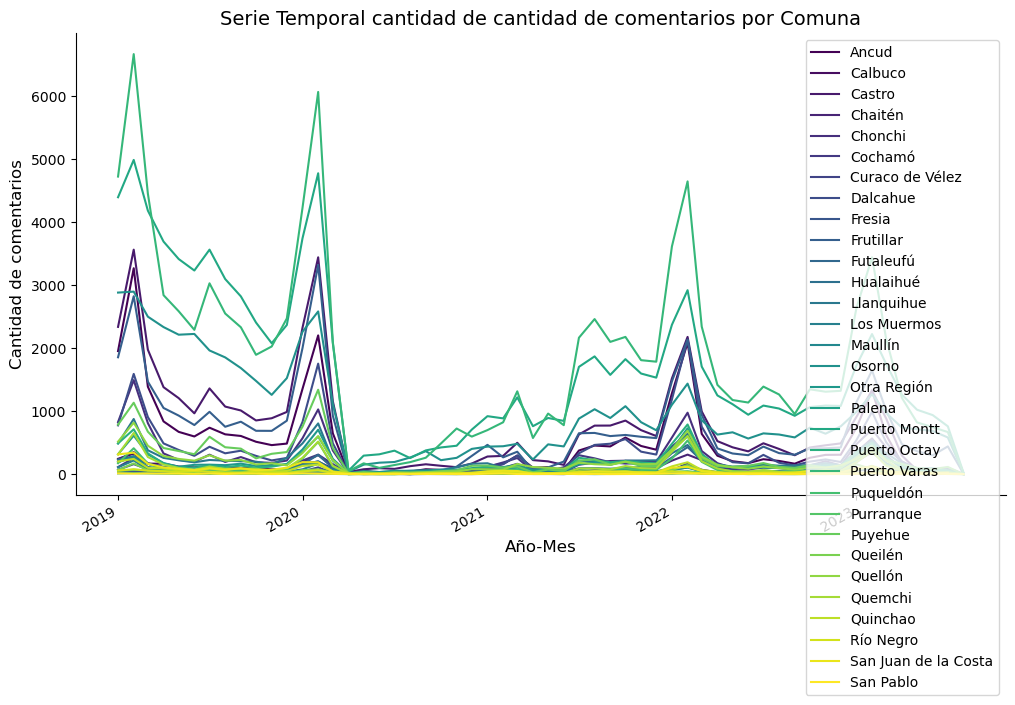

In [12]:
# Unión de datos y preprocesamiento
datos_comuna = datos_original.merge(df_concatenado, on='placeId', how='outer')
datos_comuna['Comuna'] = datos_comuna['Comuna'].fillna('Otra Región')
datos_comuna['publishedAtDate'] = pd.to_datetime(datos_comuna['publishedAtDate'])
datos_comuna = datos_comuna[datos_comuna['publishedAtDate'] >= '2019-01-01']

# Creación de columnas
datos_comuna['AñoMes'] = datos_comuna['publishedAtDate'].dt.to_period('M')

# Agrupación y conteo
conteo_reviews_por_comuna_y_mes = (datos_comuna
                                    .groupby(['Comuna', 'AñoMes'])
                                    .size()
                                    .reset_index(name='CantidadComentarios')
                                    .rename(columns={'AñoMes': 'Fecha'}))

# Visualización
color_map = cm.get_cmap('viridis', len(conteo_reviews_por_comuna_y_mes['Comuna'].unique()))

plt.figure(figsize=(12, 6))
ax = plt.gca()

for i, comuna in enumerate(conteo_reviews_por_comuna_y_mes['Comuna'].unique()):
    datos_comuna = conteo_reviews_por_comuna_y_mes[conteo_reviews_por_comuna_y_mes['Comuna'] == comuna]
    ax.plot(datos_comuna['Fecha'].dt.to_timestamp(), datos_comuna['CantidadComentarios'], label=comuna, color=color_map(i))

ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de cantidad de comentarios por Comuna', fontsize=14)
ax.legend()
plt.xticks(rotation=30, ha='right')
hide_border(ax)
plt.show()



### 2.2.a Correlación

**Correlación de la cantidad de comentarios entre comunas**

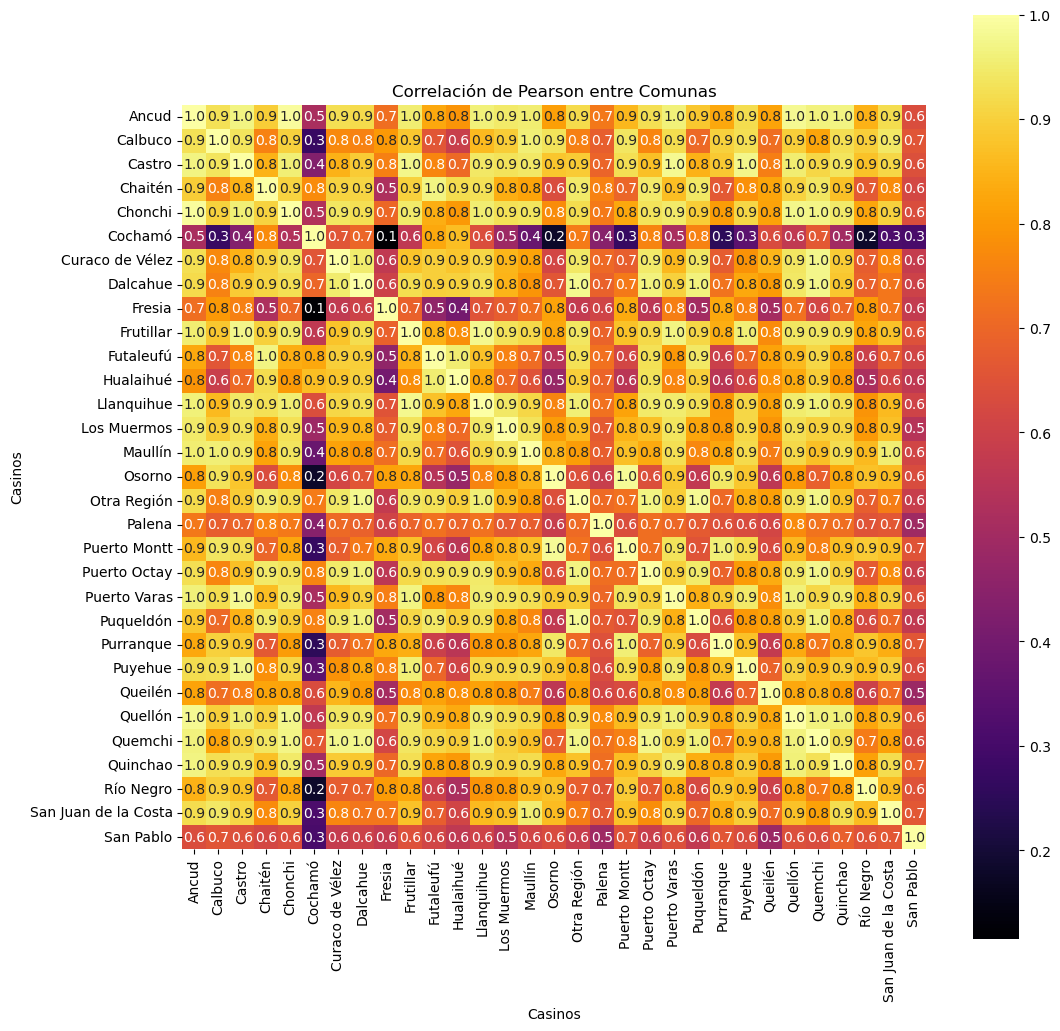

In [13]:
# Pivoteamos el DataFrame para reorganizarlo
pivot_df = conteo_reviews_por_comuna_y_mes.pivot(index='Fecha', columns='Comuna', values='CantidadComentarios')

# Calcular la correlación de Pearson
correlacion_pearson = pivot_df.corr()
correlacion_pearson = correlacion_pearson.fillna(0)

# Graficar el heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlacion_pearson, annot=True, cmap='inferno', cbar=True, square=True, fmt='.1f')
plt.xlabel('Casinos')
plt.ylabel('Casinos')
plt.title('Correlación de Pearson entre Comunas')
plt.show()

## 2.3 Análisis de correlación 
**Correlación entre la cantidad de comentarios y la cantidad de visitas**

In [14]:
# Pivoteamos el DataFrame para reorganizarlo
visitas = df_suma.pivot(index='Anio-Mes', columns='Comuna', values='Valor')
visitas = visitas.fillna(0)
comentarios = conteo_reviews_por_comuna_y_mes.pivot(index='Fecha', columns='Comuna', values='CantidadComentarios')
comentarios = comentarios.drop(columns='Otra Región',axis=1)
comentarios = comentarios.fillna(0)

visitas = visitas.reset_index(drop=True)
comentarios= comentarios.reset_index(drop=True)

# Calcular la correlación de Pearson
correlacion_pearson = visitas.corrwith(comentarios, axis=0)

# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson)

Correlación de Pearson entre las columnas:
Comuna
Ancud                   0.832417
Calbuco                 0.616234
Castro                  0.866262
Chaitén                 0.853606
Chonchi                 0.824405
Cochamó                 0.902696
Curaco de Vélez         0.708997
Dalcahue                0.849032
Fresia                  0.330580
Frutillar               0.861474
Futaleufú               0.882015
Hualaihué               0.863253
Llanquihue              0.888123
Los Muermos             0.875373
Maullín                 0.791982
Osorno                  0.582926
Palena                  0.586485
Puerto Montt            0.705331
Puerto Octay            0.867717
Puerto Varas            0.769601
Puqueldón               0.781507
Purranque               0.605130
Puyehue                 0.681227
Queilén                 0.729165
Quellón                 0.817878
Quemchi                 0.803802
Quinchao                0.807138
Río Negro               0.579080
San Juan de la Costa    0.

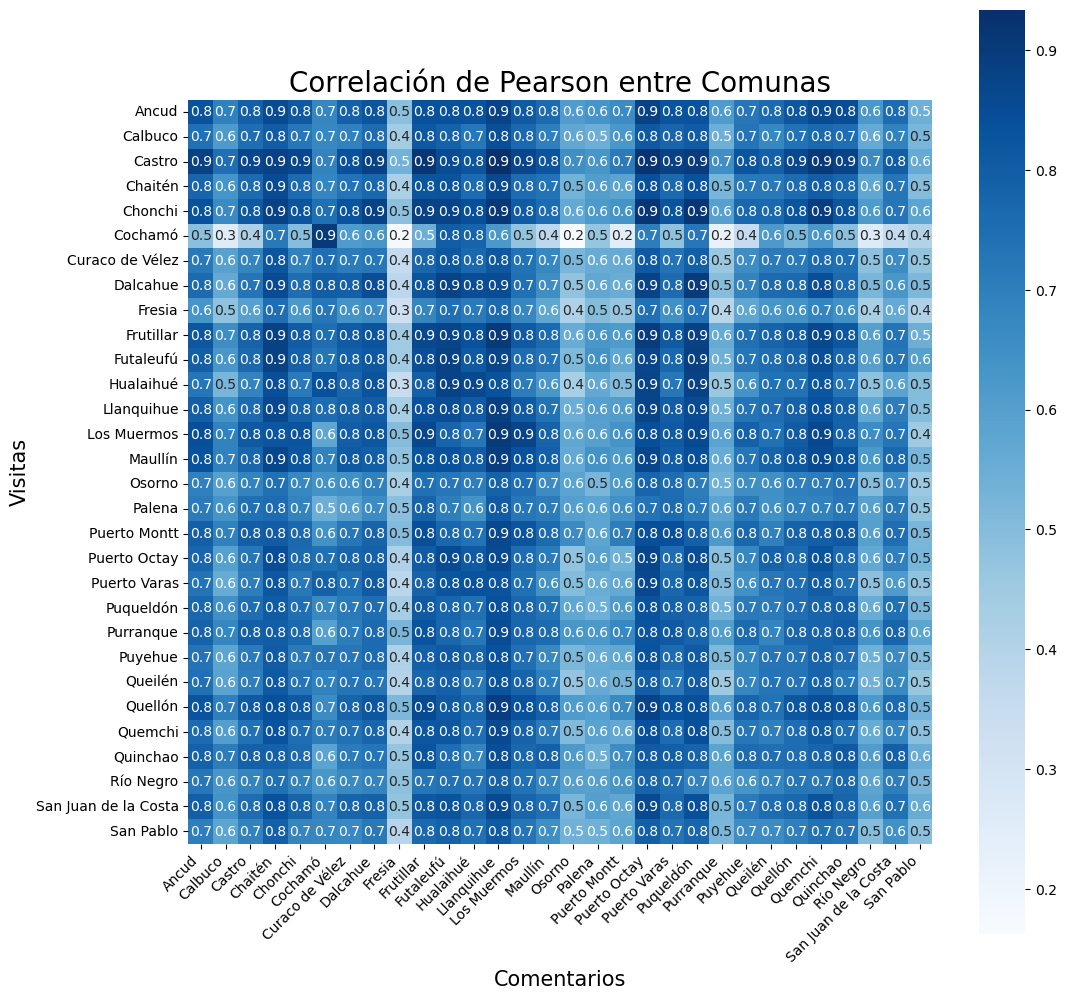

In [69]:
merged_df = pd.merge(comentarios, visitas, left_index=True, right_index=True)
corr = merged_df.corr()
matrix = corr[30:].iloc[:,0:30]

matrix.columns = visitas.columns
matrix.index = visitas.columns

# Graficar el heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, cmap='Blues', cbar=True, square=True, fmt='.1f')
plt.xlabel('Comentarios',fontsize=15)
plt.ylabel('Visitas',fontsize=15)
# Rotar las etiquetas del eje x a 45 grados
plt.xticks(rotation=45,ha='right')
plt.title('Correlación de Pearson entre Comunas',fontsize=20)
plt.show()

**Correlacion de Pearson entre todos los comentarios y visitas de todas las comunas**

In [64]:
correlacion_pearson = pd.DataFrame(visitas.sum(axis=1)).corrwith(pd.DataFrame(comentarios.sum(axis=1)), axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.8086543257727661


# Análisis 3: Alojamiento

In [15]:
# Lectura de datos
alojamiento = pd.read_excel('Base de datos/series-mensuales-de-julio-2016-a-la-fecha-LosLagos-Alojamiento-Filtrado.xlsx')

# Diccionario para mapear abreviaturas de meses a números
abreviaturas_meses = {
    'Ene': '01', 'Feb': '02', 'Mar': '03',
    'Abr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Ago': '08', 'Sept': '09',
    'Oct': '10', 'Nov': '11', 'Dic': '12'
}

# Función para convertir el formato 'YYYY/R-MM' a 'YYYY-MM'
def convertir_a_fecha(fecha_str):
    partes = fecha_str.split('-')
    return pd.to_datetime('20'+partes[1][0:2] + '-' + abreviaturas_meses[partes[0]],format='%Y-%m')

# Aplicar la función de conversión a la columna "Mes-Año"
alojamiento['Mes-Año'] = alojamiento['Mes-Año'].apply(convertir_a_fecha)
alojamiento['Mes-Año'] = pd.to_datetime(alojamiento['Mes-Año']).dt.to_period('M')
alojamiento.head()

,Mes-Año,Los Lagos
0,2016-07,10551.799020
1,2016-08,10575.093137
2,2016-09,10507.613137
3,2016-10,10513.999020
4,2016-11,10546.249020


**Las categorías que consideran en alojamiento son: bed & breakfast, hostel, hostel**

In [16]:

def categoria(palabra):
    return palabra.split(',')[0]

datos_original['Categoria query'] = datos_original['query'].apply(categoria)
datos_original.loc[datos_original['Categoria query'] == 'Restaurante', 'Categoria query'] = 'restaurant'

# Transformar 'publishedAtDate' a tipo datetime y luego a 'Mes-Año'
datos_original['publishedAtDate'] = pd.to_datetime(datos_original['publishedAtDate'])
datos_original['Mes-Año'] = datos_original['publishedAtDate'].dt.to_period('M')

# Filtrar para incluir solo los 'Mes-Año' mayores a '2016-07'
datos_original = datos_original[(datos_original['Mes-Año'] > '2016-06')&(datos_original['Mes-Año'] < '2023-08')]


In [17]:
# Seleccionar las filas con las categorías específicas
categorias_interes = ['bed & breakfast', 'hotel', 'hostel']
datos_seleccionados = datos_original[datos_original['Categoria query'].isin(categorias_interes)]

**Se filtra cuarentena análisis mesa-año**

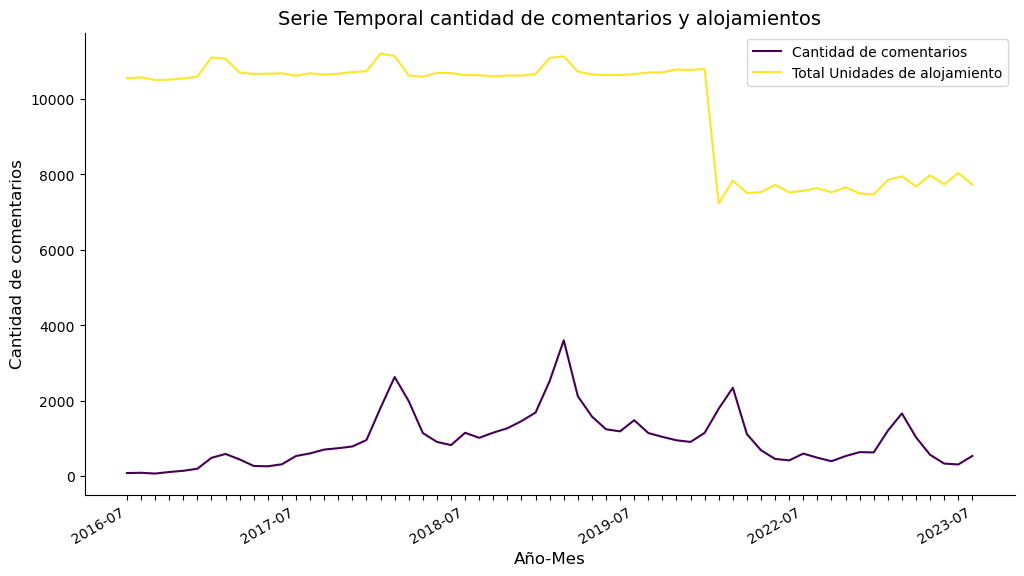

In [18]:
# Filtrar para excluir los años 2020 y 2021. Se filtra cuarentena
datos_filtrados = datos_seleccionados[~datos_seleccionados['Mes-Año'].dt.year.isin([2020, 2021])]
alojamiento_filtrado = alojamiento[(alojamiento['Mes-Año'].dt.year != 2020) & (alojamiento['Mes-Año'].dt.year != 2021)]

# Agrupar por 'Mes-Año' y contar la cantidad de 'reviewId' en cada grupo
conteo_reviewId_por_mes_ano = datos_filtrados.groupby('Mes-Año')['reviewId'].count().reset_index()

# Unir el DataFrame original con el nuevo DataFrame usando un left join
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano.merge(alojamiento_filtrado[['Mes-Año']], on='Mes-Año', how='outer')

# Llenar los valores faltantes en 'reviewId' con 0
conteo_reviewId_por_mes_ano_filtrado['reviewId'] = conteo_reviewId_por_mes_ano_filtrado['reviewId'].fillna(0).astype(int) 
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.sort_values(by='Mes-Año')

# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', 2)

# Crear una figura y ejes
plt.figure(figsize=(12, 6))
ax = plt.gca()
conteo_reviewId_por_mes_ano_filtrado['Mes-Año'] = conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.to_timestamp()
tiempo = alojamiento_filtrado['Mes-Año'].dt.to_timestamp()

ax.plot(conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.strftime('%Y-%m-%d'), conteo_reviewId_por_mes_ano_filtrado['reviewId'], label='Cantidad de comentarios', color=color_map(0))
ax.plot(tiempo.dt.strftime('%Y-%m-%d'),alojamiento_filtrado['Los Lagos'], label='Total Unidades de alojamiento', color=color_map(1))

anios = ['2016-07','','','','','','','','','','', '',
                    '2017-07', '','','','','','','','','','', '',
                    '2018-07','','','','','','','','','','', '',
                    '2019-07','','','','','','','','','','', '',
                    '2022-07','','','','','','','','','','', '',
                    '2023-07','','','','','','','','']
ax.set_xticklabels(anios)
ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de comentarios y alojamientos', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()



In [19]:
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.rename({'reviewId':'Los Lagos'},axis=1)
correlacion_pearson = conteo_reviewId_por_mes_ano_filtrado.corrwith(alojamiento_filtrado, axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.566390144421874


**Se filtra cuarentena análisis semestre-año**

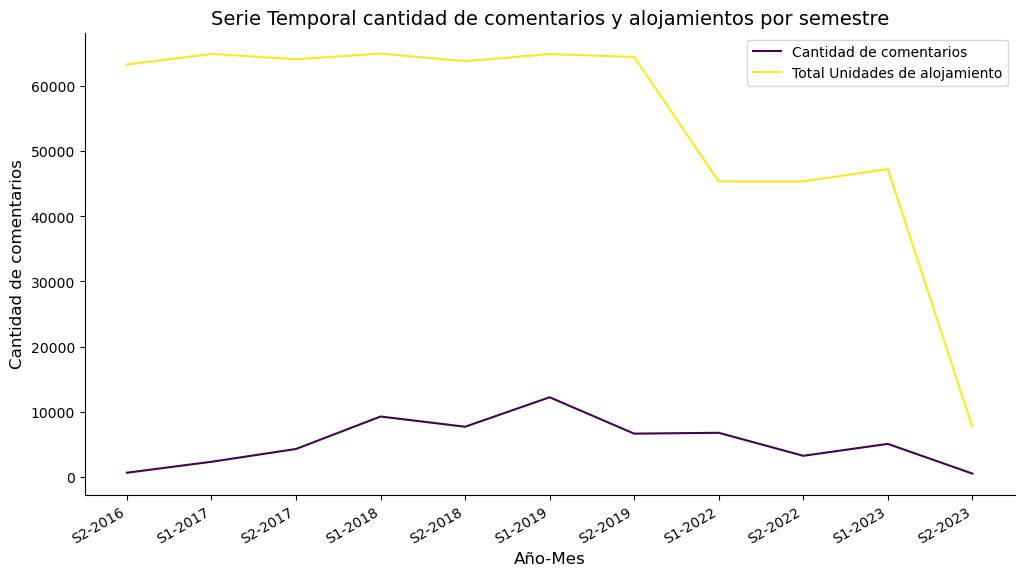

In [20]:

# Convertir 'Mes-Año' a formato de mes y año
conteo_reviewId_por_mes_ano_filtrado['Mes'] = conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.month
conteo_reviewId_por_mes_ano_filtrado['Año'] = conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.year

# Calcular el semestre
conteo_reviewId_por_mes_ano_filtrado['Semestre-Año'] = 'S' + (conteo_reviewId_por_mes_ano_filtrado['Mes'] // 7 + 1).astype(str) + '-' + conteo_reviewId_por_mes_ano_filtrado['Año'].astype(str)
conteo_por_semestre_ano = conteo_reviewId_por_mes_ano_filtrado.groupby('Semestre-Año')['Los Lagos'].sum().reset_index()

# Convertir 'Mes-Año' a formato de mes y año
alojamiento_filtrado['Mes'] = alojamiento_filtrado['Mes-Año'].dt.month
alojamiento_filtrado['Año'] = alojamiento_filtrado['Mes-Año'].dt.year

# Calcular el semestre
alojamiento_filtrado['Semestre-Año'] = 'S' + (alojamiento_filtrado['Mes'] // 7 + 1).astype(str) + '-' + alojamiento_filtrado['Año'].astype(str)

# Agrupar por semestre-año y sumar los valores de 'Los Lagos'
sum_por_semestre_ano = alojamiento_filtrado.groupby('Semestre-Año')['Los Lagos'].sum().reset_index()
# Extraer el año de 'Semestre-Año' y convertir a tipo numérico
conteo_por_semestre_ano['Año'] = conteo_por_semestre_ano['Semestre-Año'].apply(lambda x: int(x.split('-')[1]))
sum_por_semestre_ano['Año'] = sum_por_semestre_ano['Semestre-Año'].apply(lambda x: int(x.split('-')[1]))

# Ordenar por año en 'conteo_por_semestre_ano'
conteo_por_semestre_ano = conteo_por_semestre_ano.sort_values(by=['Año'])
sum_por_semestre_ano = sum_por_semestre_ano.sort_values(by=['Año'])

# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', 2)

# Crear una figura y ejes
plt.figure(figsize=(12, 6))
ax = plt.gca()


ax.plot(conteo_por_semestre_ano['Semestre-Año'],conteo_por_semestre_ano['Los Lagos'], label='Cantidad de comentarios', color=color_map(0))
ax.plot(conteo_por_semestre_ano['Semestre-Año'],sum_por_semestre_ano['Los Lagos'], label='Total Unidades de alojamiento', color=color_map(1))


ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de comentarios y alojamientos por semestre', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()


In [21]:
conteo_por_semestre_ano = conteo_por_semestre_ano.rename({'reviewId':'Los Lagos'},axis=1)
correlacion_pearson = conteo_por_semestre_ano.corrwith(sum_por_semestre_ano, axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.4675291548131863


**Se filtra cuarentena análisis trimestre-año**

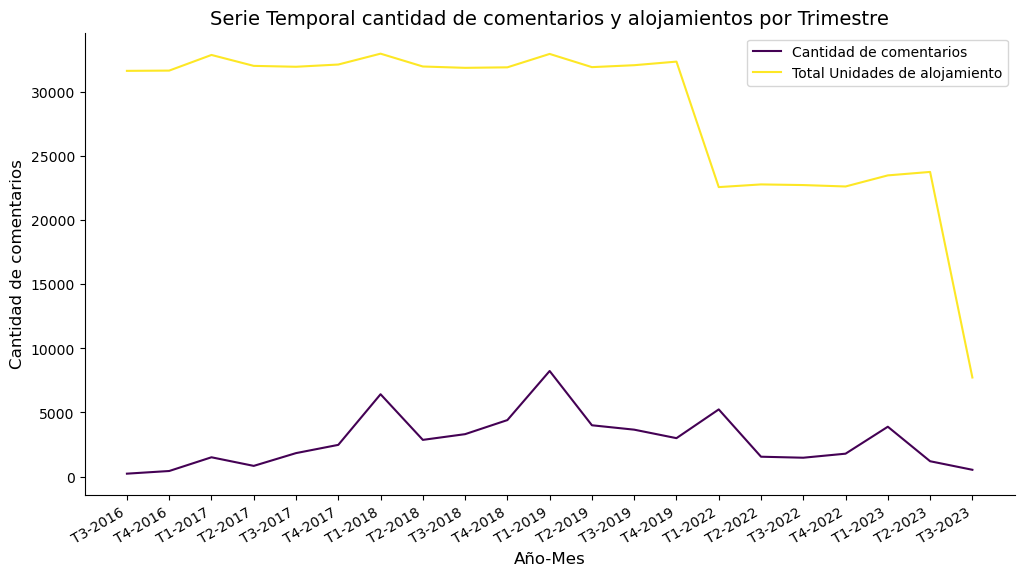

In [22]:
# Calcular el trimestre
conteo_reviewId_por_mes_ano_filtrado['Trimestre-Año'] = 'T' + ((conteo_reviewId_por_mes_ano_filtrado['Mes'] - 1) // 3 + 1).astype(str)+ '-' + conteo_reviewId_por_mes_ano_filtrado['Año'].astype(str)
conteo_por_trimestre_ano = conteo_reviewId_por_mes_ano_filtrado.groupby('Trimestre-Año')['Los Lagos'].sum().reset_index()

# Calcular el trimestre
alojamiento_filtrado['Trimestre-Año'] = 'T' + ((alojamiento_filtrado['Mes'] - 1) // 3 + 1).astype(str) + '-' + alojamiento_filtrado['Año'].astype(str)
sum_por_trimestre_ano = alojamiento_filtrado.groupby('Trimestre-Año')['Los Lagos'].sum().reset_index()
conteo_por_trimestre_ano['Año'] = conteo_por_trimestre_ano['Trimestre-Año'].apply(lambda x: int(x.split('-')[1]))
sum_por_trimestre_ano['Año'] = sum_por_trimestre_ano['Trimestre-Año'].apply(lambda x: int(x.split('-')[1]))

# Función para obtener el trimestre numérico
def obtener_trimestre(trimestre_ano):
    trimestre, _ = trimestre_ano.split('-')
    if trimestre.startswith('T'):
        return int(trimestre[1:])
    return int(trimestre)


# Obtener el trimestre numérico y ordenar por año y trimestre en 'conteo_por_trimestre_ano'
conteo_por_trimestre_ano['Trimestre'] = conteo_por_trimestre_ano['Trimestre-Año'].apply(obtener_trimestre)
conteo_por_trimestre_ano.sort_values(by=['Año', 'Trimestre'], inplace=True)



# Obtener el trimestre numérico y ordenar por año y trimestre en 'sum_por_trimestre_ano'
sum_por_trimestre_ano['Trimestre'] = sum_por_trimestre_ano['Trimestre-Año'].apply(obtener_trimestre)
sum_por_trimestre_ano.sort_values(by=['Año', 'Trimestre'], inplace=True)


# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', 2)

# Crear una figura y ejes
plt.figure(figsize=(12, 6))
ax = plt.gca()


ax.plot(conteo_por_trimestre_ano['Trimestre-Año'],conteo_por_trimestre_ano['Los Lagos'], label='Cantidad de comentarios', color=color_map(0))
ax.plot(sum_por_trimestre_ano['Trimestre-Año'],sum_por_trimestre_ano['Los Lagos'], label='Total Unidades de alojamiento', color=color_map(1))


ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de comentarios y alojamientos por Trimestre', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()

In [23]:
correlacion_pearson = conteo_por_trimestre_ano.corrwith(sum_por_trimestre_ano, axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.29975444004655527


**NO se filtra cuarentena**

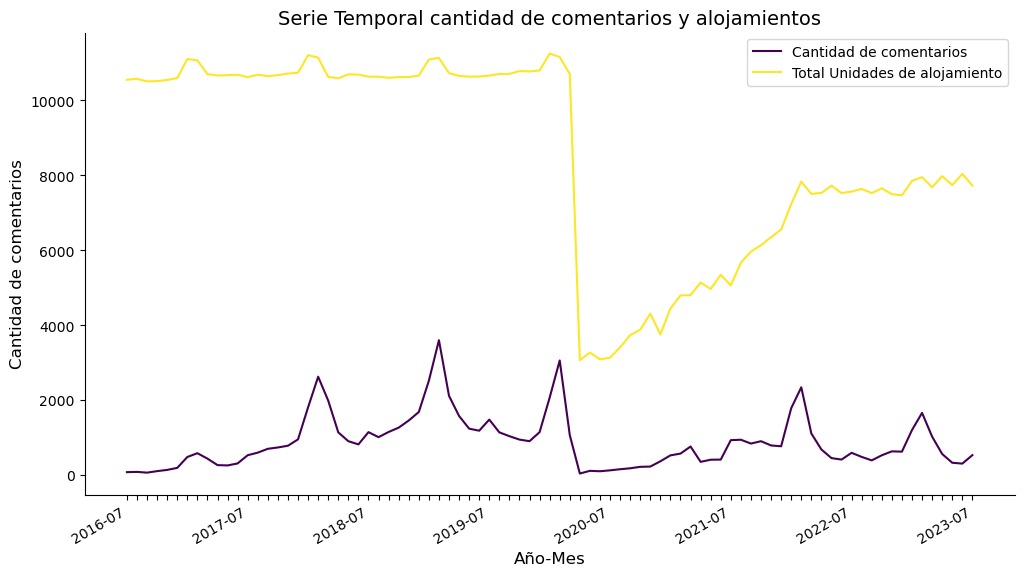

In [24]:
# Agrupar por 'Mes-Año' y contar la cantidad de 'reviewId' en cada grupo
conteo_reviewId_por_mes_ano = datos_seleccionados.groupby('Mes-Año')['reviewId'].count().reset_index()

# Unir el DataFrame original con el nuevo DataFrame usando un left join
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano.merge(alojamiento[['Mes-Año']], on='Mes-Año', how='outer')

# Llenar los valores faltantes en 'reviewId' con 0
conteo_reviewId_por_mes_ano_filtrado['reviewId'] = conteo_reviewId_por_mes_ano_filtrado['reviewId'].fillna(0).astype(int) 
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.sort_values(by='Mes-Año')

# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', 2)

# Crear una figura y ejes
plt.figure(figsize=(12, 6))
ax = plt.gca()
conteo_reviewId_por_mes_ano_filtrado['Mes-Año'] = conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.to_timestamp()
tiempo = alojamiento['Mes-Año'].dt.to_timestamp()

ax.plot(conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.strftime('%Y-%m-%d'), conteo_reviewId_por_mes_ano_filtrado['reviewId'], label='Cantidad de comentarios', color=color_map(0))
ax.plot(tiempo.dt.strftime('%Y-%m-%d'),alojamiento['Los Lagos'], label='Total Unidades de alojamiento', color=color_map(1))

anios = ['2016-07','','','','','','','','','','', '',
                    '2017-07', '','','','','','','','','','', '',
                    '2018-07','','','','','','','','','','', '',
                    '2019-07','','','','','','','','','','', '',
                    '2020-07','','','','','','','','','','', '',
                    '2021-07','','','','','','','','','','', '',
                    '2022-07','','','','','','','','','','', '',
                    '2023-07','','','','','','','','']
ax.set_xticklabels(anios)
ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de comentarios y alojamientos', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()


In [25]:
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.rename({'reviewId':'Los Lagos'},axis=1)
correlacion_pearson = conteo_reviewId_por_mes_ano_filtrado.corrwith(alojamiento, axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.4290222306810736


**Todos los reviwes sin cuarentena**

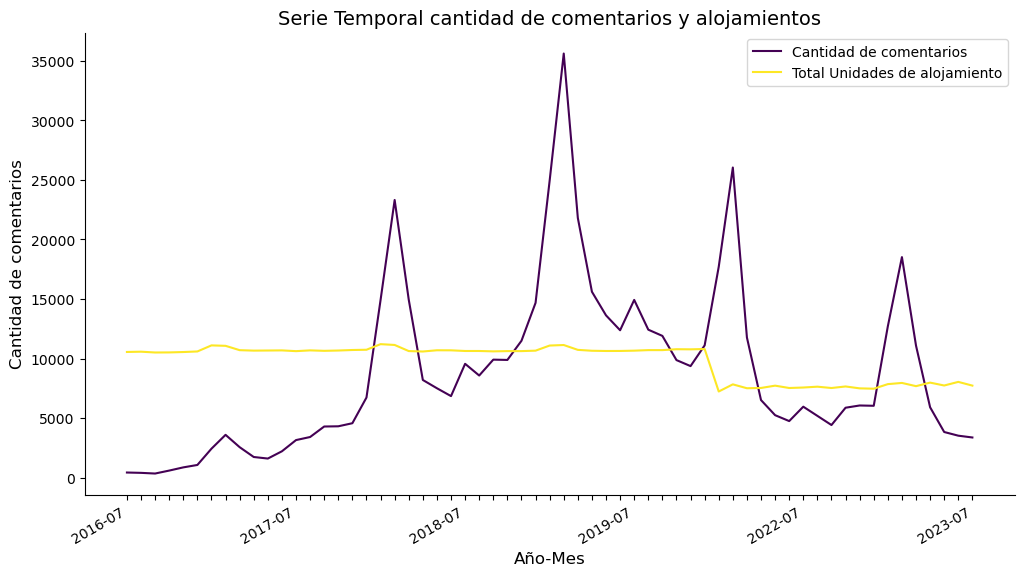

In [26]:
# Filtrar para excluir los años 2020 y 2021. Se filtra cuarentena
datos_filtrados = datos_original[~datos_original['Mes-Año'].dt.year.isin([2020, 2021])]
alojamiento_filtrado = alojamiento[(alojamiento['Mes-Año'].dt.year != 2020) & (alojamiento['Mes-Año'].dt.year != 2021)]

# Agrupar por 'Mes-Año' y contar la cantidad de 'reviewId' en cada grupo
conteo_reviewId_por_mes_ano = datos_filtrados.groupby('Mes-Año')['reviewId'].count().reset_index()

# Unir el DataFrame original con el nuevo DataFrame usando un left join
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano.merge(alojamiento_filtrado[['Mes-Año']], on='Mes-Año', how='outer')

# Llenar los valores faltantes en 'reviewId' con 0
conteo_reviewId_por_mes_ano_filtrado['reviewId'] = conteo_reviewId_por_mes_ano_filtrado['reviewId'].fillna(0).astype(int) 
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.sort_values(by='Mes-Año')

# Crear una lista de colores para diferenciar cada comuna
color_map = cm.get_cmap('viridis', 2)

# Crear una figura y ejes
plt.figure(figsize=(12, 6))
ax = plt.gca()
conteo_reviewId_por_mes_ano_filtrado['Mes-Año'] = conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.to_timestamp()
alojamiento_filtrado['Mes-Año'] = alojamiento_filtrado['Mes-Año'].dt.to_timestamp()

ax.plot(conteo_reviewId_por_mes_ano_filtrado['Mes-Año'].dt.strftime('%Y-%m-%d'), conteo_reviewId_por_mes_ano_filtrado['reviewId'], label='Cantidad de comentarios', color=color_map(0))
ax.plot(alojamiento_filtrado['Mes-Año'].dt.strftime('%Y-%m-%d'),alojamiento_filtrado['Los Lagos'], label='Total Unidades de alojamiento', color=color_map(1))

anios = ['2016-07','','','','','','','','','','', '',
                    '2017-07', '','','','','','','','','','', '',
                    '2018-07','','','','','','','','','','', '',
                    '2019-07','','','','','','','','','','', '',
                    '2022-07','','','','','','','','','','', '',
                    '2023-07','','','','','','','','']
ax.set_xticklabels(anios)
ax.set_xlabel('Año-Mes', fontsize=12)
ax.set_ylabel('Cantidad de comentarios', fontsize=12)
ax.set_title('Serie Temporal cantidad de comentarios y alojamientos', fontsize=14)
ax.legend()
plt.xticks(rotation=30,ha='right')
hide_border(ax)
plt.show()




In [27]:
conteo_reviewId_por_mes_ano_filtrado = conteo_reviewId_por_mes_ano_filtrado.rename({'reviewId':'Los Lagos'},axis=1)
correlacion_pearson = conteo_reviewId_por_mes_ano_filtrado.corrwith(alojamiento, axis=0)
# Imprimir la correlación de Pearson
print("Correlación de Pearson entre las columnas:")
print(correlacion_pearson[0])


Correlación de Pearson entre las columnas:
0.2114513452917349


In [29]:
import pandas as pd

data = {
    'Comuna': ['Ancud', 'Calbuco', 'Castro', 'Chaitén', 'Chonchi', 'Cochamó', 'Curaco de Vélez', 'Dalcahue', 'Fresia', 'Frutillar',
               'Futaleufú', 'Hualaihué', 'Llanquihue', 'Los Muermos', 'Maullín', 'Osorno', 'Palena', 'Puerto Montt', 'Puerto Octay',
               'Puerto Varas', 'Puqueldón', 'Purranque', 'Puyehue', 'Queilén', 'Quellón', 'Quemchi', 'Quinchao', 'Río Negro',
               'San Juan de la Costa', 'San Pablo'],
    'Correlación Pearson': [0.832417, 0.616234, 0.866262, 0.853606, 0.824405, 0.902696, 0.708997, 0.849032, 0.330580, 0.861474,
                            0.882015, 0.863253, 0.888123, 0.875373, 0.791982, 0.582926, 0.586485, 0.705331, 0.867717, 0.769601,
                            0.781507, 0.605130, 0.681227, 0.729165, 0.817878, 0.803802, 0.807138, 0.579080, 0.742392, 0.488157]
}

df = pd.DataFrame(data)

df


,Comuna,Correlación Pearson
0,Ancud,0.832417
1,Calbuco,0.616234
2,Castro,0.866262
3,Chaitén,0.853606
4,Chonchi,0.824405
5,Cochamó,0.902696
6,Curaco de Vélez,0.708997
7,Dalcahue,0.849032
8,Fresia,0.330580
9,Frutillar,0.861474
